## **Library**

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from tqdm import tqdm
import time

from PIL import Image
from torchvision import transforms
from torchvision.transforms import Resize
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from torchvision.transforms.functional import InterpolationMode

## **Dataset**

In [2]:
# Transform
transform = transforms.Compose([
        transforms.Resize((150,150),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        #transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ])

In [3]:
class HelmetDataset(Dataset):
    def __init__(self, df, root_dir, transform, target_transform):
        self.root_dir = root_dir
        self.df = df
        self.transform = transform
        self.target_transform = target_transform

    def get_image(self, row):
        """Gets the image for a given row"""
        image_path = os.path.join(self.root_dir,str(row['id'])+".jpg")
        image = Image.open(image_path).convert('RGB')
        return image

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = self.get_image(row)
        label = torch.as_tensor(row['class_id'],dtype=torch.long)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [4]:
# Phân chia dữ liệu thành tập train và tập test
train_data = pd.read_csv(r"/kaggle/input/resnet-dataset/Data/Data/Ground_truth/gt_resnet_train.csv")
test_data = pd.read_csv(r"/kaggle/input/resnet-dataset/Data/Data/Ground_truth/gt_resnet_val.csv")
train_dir = r"/kaggle/input/resnet-dataset/Data/Data/Train"
test_dir = r"/kaggle/input/resnet-dataset/Data/Data/Test"
# Phân chia dữ liệu thành tập train và tập test
train_data, val_data = train_test_split(train_data, test_size=0.2)

In [5]:
print("Len train data:",len(train_data))
print("Len val_data:",len(val_data))
print("Len test_data:",len(test_data))

Len train data: 26168
Len val_data: 6542
Len test_data: 5086


In [6]:
BATCH_SIZE = 128
NUM_WORKERS = 1

train_dataset = HelmetDataset(df = train_data, root_dir = train_dir, transform = transform, target_transform = None)
val_dataset = HelmetDataset(df = val_data, root_dir = train_dir, transform = transform, target_transform = None)
test_dataset = HelmetDataset(df = test_data, root_dir = test_dir, transform = transform, target_transform = None)

dl_train = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=NUM_WORKERS)
dl_val = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                    num_workers=NUM_WORKERS)
dl_test = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                    num_workers=NUM_WORKERS)

## **Model**

In [7]:
device = torch.device('cuda')

In [8]:
# Load pre-trained ResNet-50
resnet = models.resnet101(weights=False)
resnet = nn.Sequential(*list(resnet.children())[:-1])
mlp = nn.Sequential(
    nn.Linear(2048, 2),
)
# Kết hợp ResNet và MLP
class CombinedModel(nn.Module):
    def __init__(self, encoder, head):
        super(CombinedModel, self).__init__()
        self.encoder = encoder
        self.head = head

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.head(x)
        return x

# Tạo mô hình hoàn chỉnh
model = CombinedModel(resnet, mlp).to(device)
# Chọn hàm mất mát và tối ưu hóa
weights = torch.tensor([0.6, 0.4])
criterion = nn.CrossEntropyLoss(weight=weights).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [9]:
best_loss = 10**5
num_epochs = 30
train_losses = []
train_acc = []
val_losses = []
val_acc = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0.0
    accuracy = 0
    cnt = 0
    time_start = time.time()
    for X, y in dl_train:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        accuracy += (torch.argmax(outputs, 1) == y).sum().item()
        cnt += len(y)
    train_loss /= len(dl_train)
    train_losses.append(train_loss)
    accuracy /= cnt
    train_acc.append(accuracy)


    model.eval()
    val_loss = 0.0
    val_accuracy = 0
    cnt = 0
    with torch.no_grad():
        for X, y in dl_val:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            val_loss += loss.item()
            val_accuracy += (torch.argmax(outputs, 1) == y).sum().item()
            cnt += len(y)
    val_loss /= len(dl_val)
    val_losses.append(val_loss)
    val_accuracy /= cnt
    val_acc.append(val_accuracy)
    
    elapsed = time.time() - time_start
    
    # Save checkpoint
    chk_name = f'/kaggle/working/pytorch_model_e{epoch}.bin'
    torch.save(model.state_dict(), chk_name)
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), '/kaggle/working/pytorch_model.bin')

    print(f"Epoch {epoch+1}/{num_epochs}, Train_Loss: {train_loss:.4f},  Train_Acc: {accuracy:.4f}, Val_Loss: {val_loss:.4f},  Val_Acc: {val_accuracy:.4f}, [{elapsed/60:.0f} mins]")

  3%|▎         | 1/30 [05:02<2:26:24, 302.90s/it]

Epoch 1/30, Train_Loss: 0.6276,  Train_Acc: 0.7198, Val_Loss: 0.5429,  Val_Acc: 0.7411, [5 mins]


  7%|▋         | 2/30 [09:31<2:11:52, 282.59s/it]

Epoch 2/30, Train_Loss: 0.3756,  Train_Acc: 0.8412, Val_Loss: 0.5189,  Val_Acc: 0.7889, [4 mins]


 10%|█         | 3/30 [13:59<2:04:11, 275.98s/it]

Epoch 3/30, Train_Loss: 0.2626,  Train_Acc: 0.8932, Val_Loss: 0.3793,  Val_Acc: 0.8283, [4 mins]


 13%|█▎        | 4/30 [18:28<1:58:20, 273.11s/it]

Epoch 4/30, Train_Loss: 0.2050,  Train_Acc: 0.9178, Val_Loss: 0.3192,  Val_Acc: 0.8965, [4 mins]


 17%|█▋        | 5/30 [22:56<1:53:05, 271.41s/it]

Epoch 5/30, Train_Loss: 0.1607,  Train_Acc: 0.9381, Val_Loss: 0.2394,  Val_Acc: 0.9156, [4 mins]


 20%|██        | 6/30 [27:24<1:48:07, 270.32s/it]

Epoch 6/30, Train_Loss: 0.1270,  Train_Acc: 0.9528, Val_Loss: 0.2394,  Val_Acc: 0.9138, [4 mins]


 23%|██▎       | 7/30 [31:52<1:43:18, 269.49s/it]

Epoch 7/30, Train_Loss: 0.1049,  Train_Acc: 0.9605, Val_Loss: 0.2112,  Val_Acc: 0.9253, [4 mins]


 27%|██▋       | 8/30 [36:20<1:38:39, 269.06s/it]

Epoch 8/30, Train_Loss: 0.1104,  Train_Acc: 0.9599, Val_Loss: 0.6717,  Val_Acc: 0.8442, [4 mins]


 30%|███       | 9/30 [40:48<1:34:04, 268.77s/it]

Epoch 9/30, Train_Loss: 0.1005,  Train_Acc: 0.9629, Val_Loss: 0.2020,  Val_Acc: 0.9329, [4 mins]


 33%|███▎      | 10/30 [45:16<1:29:30, 268.51s/it]

Epoch 10/30, Train_Loss: 0.0638,  Train_Acc: 0.9778, Val_Loss: 0.2665,  Val_Acc: 0.9330, [4 mins]


 37%|███▋      | 11/30 [49:44<1:24:56, 268.21s/it]

Epoch 11/30, Train_Loss: 0.0570,  Train_Acc: 0.9804, Val_Loss: 0.2193,  Val_Acc: 0.9249, [4 mins]


 40%|████      | 12/30 [54:12<1:20:28, 268.23s/it]

Epoch 12/30, Train_Loss: 0.0578,  Train_Acc: 0.9795, Val_Loss: 0.1699,  Val_Acc: 0.9544, [4 mins]


 43%|████▎     | 13/30 [58:40<1:15:57, 268.08s/it]

Epoch 13/30, Train_Loss: 0.0547,  Train_Acc: 0.9811, Val_Loss: 0.2292,  Val_Acc: 0.9384, [4 mins]


 47%|████▋     | 14/30 [1:03:07<1:11:26, 267.90s/it]

Epoch 14/30, Train_Loss: 0.0461,  Train_Acc: 0.9839, Val_Loss: 0.2106,  Val_Acc: 0.9439, [4 mins]


 50%|█████     | 15/30 [1:07:35<1:06:57, 267.85s/it]

Epoch 15/30, Train_Loss: 0.0417,  Train_Acc: 0.9851, Val_Loss: 0.2213,  Val_Acc: 0.9402, [4 mins]


 53%|█████▎    | 16/30 [1:12:03<1:02:29, 267.79s/it]

Epoch 16/30, Train_Loss: 0.0435,  Train_Acc: 0.9841, Val_Loss: 0.1790,  Val_Acc: 0.9445, [4 mins]


 57%|█████▋    | 17/30 [1:16:31<58:03, 267.93s/it]  

Epoch 17/30, Train_Loss: 0.0445,  Train_Acc: 0.9837, Val_Loss: 0.1698,  Val_Acc: 0.9497, [4 mins]


 60%|██████    | 18/30 [1:20:59<53:35, 267.93s/it]

Epoch 18/30, Train_Loss: 0.0343,  Train_Acc: 0.9876, Val_Loss: 0.2197,  Val_Acc: 0.9334, [4 mins]


 63%|██████▎   | 19/30 [1:25:26<49:06, 267.84s/it]

Epoch 19/30, Train_Loss: 0.0419,  Train_Acc: 0.9857, Val_Loss: 0.2869,  Val_Acc: 0.9375, [4 mins]


 67%|██████▋   | 20/30 [1:29:54<44:38, 267.84s/it]

Epoch 20/30, Train_Loss: 0.0303,  Train_Acc: 0.9895, Val_Loss: 0.2173,  Val_Acc: 0.9476, [4 mins]


 70%|███████   | 21/30 [1:34:22<40:09, 267.71s/it]

Epoch 21/30, Train_Loss: 0.0341,  Train_Acc: 0.9879, Val_Loss: 0.2492,  Val_Acc: 0.9415, [4 mins]


 73%|███████▎  | 22/30 [1:38:49<35:41, 267.65s/it]

Epoch 22/30, Train_Loss: 0.0367,  Train_Acc: 0.9864, Val_Loss: 0.1997,  Val_Acc: 0.9433, [4 mins]


 77%|███████▋  | 23/30 [1:43:16<31:12, 267.53s/it]

Epoch 23/30, Train_Loss: 0.0299,  Train_Acc: 0.9899, Val_Loss: 0.1912,  Val_Acc: 0.9508, [4 mins]


 80%|████████  | 24/30 [1:47:44<26:45, 267.61s/it]

Epoch 24/30, Train_Loss: 0.0282,  Train_Acc: 0.9901, Val_Loss: 0.1687,  Val_Acc: 0.9522, [4 mins]


 83%|████████▎ | 25/30 [1:52:12<22:17, 267.53s/it]

Epoch 25/30, Train_Loss: 0.0278,  Train_Acc: 0.9908, Val_Loss: 0.2459,  Val_Acc: 0.9326, [4 mins]


 87%|████████▋ | 26/30 [1:56:39<17:49, 267.47s/it]

Epoch 26/30, Train_Loss: 0.0259,  Train_Acc: 0.9916, Val_Loss: 0.2110,  Val_Acc: 0.9378, [4 mins]


 90%|█████████ | 27/30 [2:01:06<13:21, 267.33s/it]

Epoch 27/30, Train_Loss: 0.0249,  Train_Acc: 0.9907, Val_Loss: 0.2797,  Val_Acc: 0.9201, [4 mins]


 93%|█████████▎| 28/30 [2:05:33<08:54, 267.17s/it]

Epoch 28/30, Train_Loss: 0.0246,  Train_Acc: 0.9913, Val_Loss: 0.2163,  Val_Acc: 0.9415, [4 mins]


 97%|█████████▋| 29/30 [2:10:00<04:27, 267.09s/it]

Epoch 29/30, Train_Loss: 0.0215,  Train_Acc: 0.9933, Val_Loss: 0.1978,  Val_Acc: 0.9557, [4 mins]


100%|██████████| 30/30 [2:14:27<00:00, 268.91s/it]

Epoch 30/30, Train_Loss: 0.0251,  Train_Acc: 0.9915, Val_Loss: 0.1958,  Val_Acc: 0.9494, [4 mins]


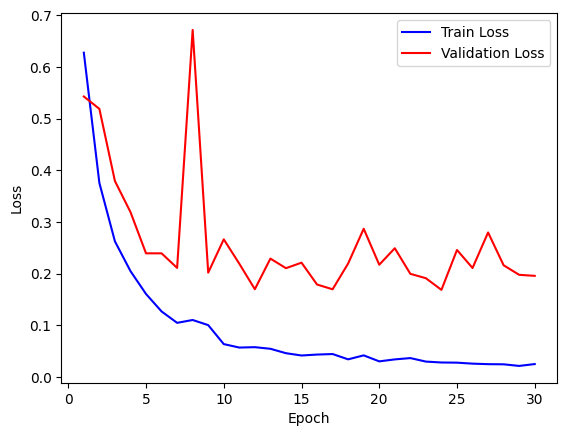

In [10]:
import matplotlib.pyplot as plt

# Số lượng epoch tương ứng với các giá trị loss
epochs = range(1, len(train_losses) + 1)

# Vẽ đồ thị
plt.plot(epochs, train_losses, 'b', label='Train Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

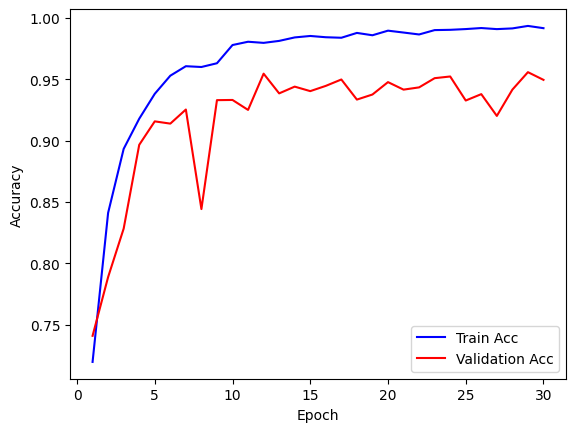

In [11]:
import matplotlib.pyplot as plt

# Số lượng epoch tương ứng với các giá trị loss
epochs = range(1, len(train_losses) + 1)

# Vẽ đồ thị
plt.plot(epochs, train_acc, 'b', label='Train Acc')
plt.plot(epochs, val_acc, 'r', label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
weight_path = "/kaggle/working/pytorch_model.bin"
test_losses = []
test_acc = []
model.load_state_dict(torch.load(weight_path))

with torch.no_grad():
    test_loss = 0.0
    test_accuracy = 0
    cnt = 0
    for X, y in dl_test:
        X, y = X.to(device), y.to(device)
        model.eval()
        outputs = model(X)
        loss = criterion(outputs, y)
        test_loss += loss.item()
        test_accuracy += (torch.argmax(outputs, 1) == y).sum().item()
        cnt += len(y)
    test_loss /= len(dl_test)
    test_losses.append(test_loss)
    test_accuracy /= cnt
    test_acc.append(test_accuracy)

In [13]:
print(test_acc)
print(test_losses)

[0.8126228863546991]
[0.8604596671648324]
